In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

# Pretty display for notebooks
%matplotlib inline


In [2]:
#Parameters
data_directory = "./data/"
output_directory = "./out/"

input_file = "listings.csv"

file_cost_and_ratings_out = "neighbourhood_cost_and_ratings.csv"

In [3]:
#Open data file
data_extended = pd.read_csv(data_directory + input_file)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
data_extended.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,14842,https://www.airbnb.com/rooms/14842,20190122134607,2019-01-22,"Best location Portobello entire house, can sle...","Beautiful entire house, newly revamped, with s...","Gorgeous, newly revamped central Dublin city e...","Beautiful entire house, newly revamped, with s...",none,Portobello is an exceptional place to live - v...,NaN,"There is great public transport - buses, Luas,...",Guests get the whole house to themselves.,I love meeting guests and I give you extensive...,"This house is a charming space, just completel...",NaN,NaN,https://a0.muscache.com/im/pictures/106656330/...,NaN,58344,https://www.airbnb.com/users/show/58344,Hilary,2009-11-29,"Dublin, County Dublin, Ireland",An easy-going and friendly Irish woman. Works ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/58344/profile...,https://a0.muscache.com/im/users/58344/profile...,NaN,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Dublin, Dublin City, Ireland",Portobello,Dublin City,NaN,Dublin,Dublin City,Dublin 8,Dublin,"Dublin, Ireland",IE,Ireland,53.331057,-6.269163,f,House,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Heating,""Family/kid ...",0.0,$119.00,NaN,NaN,$500.00,$60.00,2,$30.00,20,31,20,20,31,31,20.0,31.0,3 days ago,t,2,2,5,5,2019-01-22,42,16,2011-07-11,2019-01-02,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.46


## Cleaning some of the input data

In [6]:
#Rename some of the longer names of neighbourhoods to facilate plotting later on a Tableau Map of the city 

data_extended['host_neighbourhood'].replace('Grafton Street/St. Stephens Green','St. Stephens Green', inplace=True)
data_extended['host_neighbourhood'].replace('North City Central/O\'Connell Street','North City Central', inplace=True)



In [7]:
#Clean up the price column
#1. Get rid of dollar signs and commas
#2. Convert to floats
#3. Investigate outliers

#1. Get rid of dollar signs and commas
#2. Convert to floats
data_extended['price'] = data_extended['price'].replace('[^.0-9]', '', regex=True).astype(float)

#3. Investigate outliers
#Looking at outliers greater than 1000 dollars per night: There are 6 of these. I get rid of all six because..
#Two have broken links. Can't guarantee their integrity
#Three were found to be erroneous prices somehow. 
#One was a correct listings (very fancy rental). However this will skew results in its neighbourhood as it's..
#price is significantly than anything else in Dublin.
#??I should really dig into some of the rentals in the 500 to 1000 dollar branket to investigate.
data_extended = data_extended[~(data_extended['price'] > 1000)]

## Helper Functions

In [8]:
def get_list_of_infrequent_values(data, min_freq=10):
    
    """
    Creates a list of the most infrequent values of a column. 

    Args:
        data: Series to be investigated.
        min_freq: Below this threshold value will be included in infrequent list (default = 10).
    
    Returns:
        A list of all infrequent values in data.
    """
    v_counts = data.value_counts()
    uncommon_list = list(v_counts[v_counts < min_freq].index)    
    return uncommon_list

## Get geographic coordinates for each neighbourhood

Geographic coordinates will be needed later when results are being plotted on a map of the city in Tableau. The method used here is to take all rental properties labelled with the neighbourhood in the database and to average both their latititude and their longitude. The averages are used as the cordinates for the neighbourhood.


In [9]:
#create a copy of the data_extended data.
data_coord = data_extended.copy()

In [10]:
#1. Remove rows that have NaN for neighbourhood and coordinates
data_coord.dropna(subset=['host_neighbourhood', 'latitude', 'longitude'], inplace=True)

In [11]:
#Get rid of neighbourhoods that dont have enough samples

#The min number of times the neighbourhood needs to feature in the list to be considered for comparision 
min_freq = 5

ignore_these_areas = get_list_of_infrequent_values(data_coord['host_neighbourhood'] , min_freq)
print(ignore_these_areas)

#get rid of the datapoints that are in the neigbourhoods to be ignored
data_coord_clean = data_coord[~data_coord['host_neighbourhood'].isin(ignore_these_areas)].copy()

#Remove a couple of specific neighbourhoods (ones that should not be included in the Dublin data)
data_coord_clean = data_coord_clean[~(data_coord_clean['host_neighbourhood'].isin(['Terézváros - District VI.', 'Isle of Dogs']))]

['Donnycarney', 'Grace Park', 'De Pijp', 'Ixelles', 'Downtown Montreal', 'Richmond District', 'Fulham', 'Kilmore', 'MLK & 183', 'Woluwe-Saint-Lambert', 'Edenmore', 'LB of Haringey', 'Marine Parade', 'West Village', 'Rose Bay/Dover Heights', 'Oud-West', 'Tour Eiffel - Champ de Mars', 'Passy', 'Saint-Germain-des-Prés - Odéon', 'Opéra - Grands Boulevards', 'Auteuil', 'French Riviera']


In [12]:
coord_groups = data_coord_clean[['latitude', 'longitude']].groupby(data_coord_clean['host_neighbourhood'])
coordinates = coord_groups.mean()

## Fill in missing values for neighbourhoods

Around 33% of the host neighbourhoods are missing. We can fill this data in by using the geographic coordinates caculated above to see which neighbourhood is nearest.

However, for this analysis, I consider the sample of 6362 rentals in Dublin to be sufficient for comparing average ratings in the different neighbourhoods.

In [13]:
data_extended.shape

(9511, 106)

In [14]:
data_extended['host_neighbourhood'].isna().sum()

3155

## What are the most expensive areas of the city to rent an Airbnb property?

The aim here is, for each neighbourhood, to break down the rentals into private rooms, single bed apartments, and 2 bed apartments. Then, for each of the 3 categories get an average. The average of these 3 averages will be used to represent the average cost of a rental for that area.

Neighbourhoods get dumped from the statistics if they dont have a minimum number of properties in the 3 categories mentioned above: private rooms, single bedroom house/apt and double bedroom house/apt. This is a bit rough as we are losing the oppurtunity to report on some of those neighbourhoods. Some form of imputing could have been considered when averaging the results if one of the categories was missing.


The get_average_per_neighbourhood() function can be used with the Airbnb data for any city. Data is available at the following location: http://insideairbnb.com/get-the-data.html.

In [15]:
def get_average_per_neighbourhood(city_data_listings, column, min_freq_of_neighbourhood ):
    """
    Gets the average value of ratings_column grouped by values of 'host_neighbourhood'. 

    Args:
        city_data_listings: Dataframe to be investigated.
        column: The column to get the average of.
        min_freq_of_neighbourhood: Below this threshold of frequency neighbourhoods will be removed(default = 10).
    Returns:
        Series of means for each neighbourhood in the dataset.
    """
    #The min number of times the neighbourhood needs to feature in the list to be considered for comparision 
    
    #create a copy of the data_extended data
    #and then this function will work on the data inplace
    city_data = city_data_listings.copy()
    
    #Remove rows that have NaN for neighbourhood
    city_data.dropna(subset=['host_neighbourhood'], inplace=True)

    #Remove rows that have NaN for Location Rating
    city_data.dropna(subset=[column], inplace=True) 
    
    #Get rid of neighbourhoods that dont have enough samples   
    ignore_these_areas = get_list_of_infrequent_values(city_data['host_neighbourhood'] , min_freq_of_neighbourhood)
    #print(ignore_these_areas)
    #get rid of the datapoints that are in the neigbourhoods to be ignored
    city_data = city_data[~city_data['host_neighbourhood'].isin(ignore_these_areas)]
    
    #Group the rentals into neighbourhoods and then get the means for each neighbourhood
    rating_groups = city_data[column].groupby(city_data['host_neighbourhood'])
    ratings = rating_groups.mean()
    
    return ratings


In [16]:
#Calculate the average price for 3 different datasets (one for each of the rental type categories that we are considering)
groups_privateroom = get_average_per_neighbourhood(data_extended[data_extended['room_type'] == 'Private room'], 'price', 5)
groups_entire_1bed = get_average_per_neighbourhood(data_extended[(data_extended['room_type'] == 'Entire home/apt') & (data_extended['bedrooms'] == 1.0)], 'price', 5)
groups_entire_2bed = get_average_per_neighbourhood(data_extended[(data_extended['room_type'] == 'Entire home/apt') & (data_extended['bedrooms'] == 2.0)], 'price', 5)


In [17]:
data_extended[(data_extended['room_type'] == 'Entire home/apt') & (data_extended['bedrooms'] == 2.0)].shape

(1887, 106)

In [18]:
#Calculate an average across the 3 property types
averages = (groups_privateroom+ groups_entire_1bed + groups_entire_2bed)/3
#Remove some neighbourhoods that did not qualify for all three categories of rental
averages = averages.dropna()

#Convert from dollar to Euro (roughly using price of 22nd March 2019) 
#..and convert to int to faciliate clear display in Tableau
averages = (averages * 0.89).map('{:,.0f}'.format)
#'{:,.0f}'.format


## Which areas get the best average location rating score?

In [20]:
ratings = get_average_per_neighbourhood(data_extended, 'review_scores_location', 20)

## Save neighbourhood average cost and ratings to a file

Write to a CSV file for export to facilite Tableau Map generation.

1. First work out what the commom neighbourhoods for both data structures is as we don't want incomplete data for a neighbourgood in our Tableau map plots.
2. For each neighbourhood in the ratings table write the coordinates of the neighbourhood, the average cost of the neighbourhood and the average ratings for that neighbourhood. 


In [21]:
neighbourhoods_of_interest = list(set(ratings.index) & set(averages.index))
#extract relevent coordinates
data_with_coords = coordinates[ coordinates.index.isin(neighbourhoods_of_interest) ].copy()
#Combine average cost with the corordinates data
data_with_coords['cost'] = averages.values[averages.index.isin(neighbourhoods_of_interest)]
#Combine ratings with the corordinates data
data_with_coords['rating'] = ratings.values[ratings.index.isin(neighbourhoods_of_interest)]


#Write the ratings and coordinates to a file
data_with_coords.to_csv(output_directory + file_cost_and_ratings_out)

In [23]:
data_with_coords.head(5)

,latitude,longitude,cost,rating
host_neighbourhood,,,,
Ballsbridge,53.332205,-6.237782,123,9.709360
Ballybough,53.366412,-6.250759,70,9.066667
Blackrock,53.296121,-6.186532,82,9.411765
Booterstown,53.322641,-6.207669,87,9.558824
Cabra,53.361038,-6.287818,81,9.098592


## What's the average price over the year?


In [118]:
#in order to plot the price over the entire year of 2019 i needed 2 calendar files from Inside Airbnb. The first, was..
#the most recent avaialable and covers Jan 22 2019 t0 Jan 21 2019. I also needed an older one from December 2018 to..
#cover the first 21 days of 2019 tht I was missing

calendar_file1 = "calendar_2019_01_22.csv"
#calendar_file2 = "calendar_2018_12_16.csv"
#calendar_file3 = "calendar_2018_11_18.csv"


# Note: Unfortunetly there seems to be a discontinuity in the way that the data was colleted from file to file.
# As a result it is impossible to compare the most recent file with the older ones as thet average prices are..
#quite different. Therefore I end up only plotting the most recent calander file.

#Also note: This file, by itself,  does not truly represent the average price throughout the year. Rather, they represent the..
#the host's advertised prices for the entire year on one given day. Indtead data should be continuously colllected..
#perhaps every 2 months and compose the yearly outlook from that the combined files.



In [128]:
def transform_calendar_file(filename, data_dir):
        """
        Gets the mean price and convert to Euros a calendar file from insideairbnb.com 

        Args:
            filename: The calendar filename
            data_driectory: The directory that the file is located.
    
        Returns:
            A series with the mean for each day in the input file.
        """
        data_calendar = pd.read_csv(data_dir + filename)
        data_price = data_calendar.copy()
        #Get rid of dollar signs and commas
        #Convert to floats
        data_price['price'] = data_price['price'].replace('[^.0-9]', '', regex=True).astype(float)
        #Convert to euros using todays exchange rate (23rd March 2019)
        data_price['price'] = data_price['price'] * 0.89
        #Group means for each day
        mean_prices = data_price['price'].groupby(data_price['date']).mean()
        return mean_prices.copy()

In [129]:
mean_prices1 = transform_calendar_file(calendar_file1, data_directory)
#Note: No longer using the following file as it the averages are discontinusous from the above file so don't merge well 
#mean_prices2 = transform_calendar_file(calendar_file2, data_directory) 

In [112]:
#Extract the relevant dtes from the 2 data inputs to construct an df for the entire year
#Note: This code is only relvent if merging multiple input calendar files
mean_prices_2019 = mean_prices1['2019-01-01':'2019-01-21'].copy()
mean_prices_2019 = mean_prices_2019.append(mean_prices1['2019-01-22':'2019-12-31'])

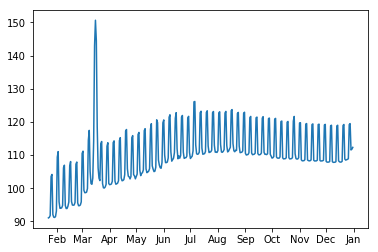

In [131]:
#import matplotlib.ticker as ticker

startdate = datetime(2019,1,22)
date_list = [startdate + timedelta(days=x) for x in range(0, 365-21)]

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig = plt.figure()
f = fig.add_subplot(1,1,1)
ax = fig.gca().xaxis
f.plot(date_list,mean_prices1['2019-01-22':'2019-12-31'].values)
ax.set_major_locator(locator)
ax.set_major_formatter(fmt)
plt.show()